In [ ]:
## NEW PYTHON CAPSTONE NOTEBOOK FOR GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score

#keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Flatten, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

#convolutional keras imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
## uncomment this cell if using google colab
##import the dataset to google colab

#from google.colab import files
#uploaded = files.upload()

Saving compressed-class-separated.pkl to compressed-class-separated.pkl


In [ ]:
##uncomment if using google colab to check that gpu is enabled for modeling
## used in google colab to see if a gpu is being used

#import tensorflow as tf
#tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
##read in the pickle file from google colab
#protein = pd.read_pickle('/content/compressed-class-separated.pkl', compression = 'gzip')
#protein.head()

,Gene ontology (molecular function),Sequence,Length,Organism,Protein names,class
0,rRNA binding [GO:0019843]; structural constitu...,MNVILLDKIANLGSLGDQVSVKSGYARNFLFPQGKAVPATKSNVDL...,150,Idiomarina loihiensis (strain ATCC BAA-735 / D...,50S ribosomal protein L9,1
1,rRNA binding [GO:0019843]; structural constitu...,MQLYDFYKKNVLIKLKNKFNYKSIMQVPKIEKITLNMGVGKASFDK...,178,Wigglesworthia glossinidia brevipalpis,50S ribosomal protein L5,1
2,rRNA binding [GO:0019843]; structural constitu...,MELKLLNDQGQAASNVAAPDTIFGRDYNEALIHQVVVAYQANARSG...,206,Janthinobacterium sp. (strain Marseille) (Mini...,50S ribosomal protein L4,1
3,rRNA binding [GO:0019843]; structural constitu...,MNVILLDKIANLGNLGDQVAVKAGYARNYLLPQGKAVVANESNVKV...,150,Shewanella sp. (strain MR-7),50S ribosomal protein L9,1
4,rRNA binding [GO:0019843]; structural constitu...,MSRVAKAPVNIPAGVEVKLDGQLLTVKGKNGELSRKIHESVEVKQD...,177,Haemophilus influenzae (strain PittGG),50S ribosomal protein L6,1


In [ ]:
#reading in the pickle file in jupyter lab
protein = pd.read_pickle('data/compressed-class-separated.pkl', compression = 'gzip')

In [ ]:
#drop the rows that aren't needed for modeling here
#only want sequence and class values
protein = protein.drop(columns = ['Gene ontology (molecular function)', 'Length', 'Organism', 'Protein names'])
protein.head(2)

,Sequence,class
0,MNVILLDKIANLGSLGDQVSVKSGYARNFLFPQGKAVPATKSNVDL...,1
1,MQLYDFYKKNVLIKLKNKFNYKSIMQVPKIEKITLNMGVGKASFDK...,1


In [ ]:
#the amount of null values in the dataframe used for modeling
protein['class'].isnull().sum()

0

## Preprocessing the Data

#### Function for Making Each Amino Acid Abbreviation a "word"

In [ ]:
## make each single letter amino acid it's own "word" for tokenizing
def make_words(sequence):
    
    """
    argument: amino acid sequence in single letter code/abbreviation
    output: input amino acid sequence with spaces between each single letter code
    """
    
    
    #instantiate empty string to concat amino acids to
    space_seq = ''
    
    #for loop to loop over each amino acid in the sequence and add it into the 
    #string with a space afterwards
    for char in sequence:
        space_seq += char
        space_seq += " "
    #remove the space at end of the new string
    return space_seq[:-1] 

In [ ]:
#apply the function to the sequence column of the dataframe
protein['Sequence'] = protein['Sequence'].apply(lambda x: make_words(x))

In [ ]:
#more views to make sure application of make_words occurred correctly
protein.head(3)

,Sequence,class
0,M N V I L L D K I A N L G S L G D Q V S V K S ...,1
1,M Q L Y D F Y K K N V L I K L K N K F N Y K S ...,1
2,M E L K L L N D Q G Q A A S N V A A P D T I F ...,1


#### Setting up X and Y for Training

In [ ]:
#set up the X and y values for the recurrent neural net
#X and y type is series
X = protein['Sequence']
y = protein['class']

In [ ]:
#train/test split the data
#stratify the split due to the unbalanced classes
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 18)

In [ ]:
#as there are only 21 "words"/1-letter amino acids we want to keep all of these
#default tokenizer splits on a white space
tokenizer = Tokenizer(21)

In [ ]:
#fit the tokenizer to the training data so it can learn the 21 "words"
tokenizer.fit_on_texts(X_train)

In [ ]:
#make the 21 "words" into sequences
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#to make the sequences all the same length pad the sequences shorter than max sequence length with zeros
x_train = pad_sequences(x_train)
x_test = pad_sequences(x_test)

## Null Model 

Before doing necessary categorization of the target values, which is required by keras neural networks, to obtain a correct input shape we should create the null model with the uncategorized target data.

In [ ]:
#creating the null model
y_train.value_counts(normalize = True)

3    0.493867
2    0.189210
1    0.153112
8    0.051204
5    0.043874
6    0.032382
7    0.024787
4    0.011564
Name: class, dtype: float64

### Null Model Explanation

The null model allows us to find a 'starting point' to compare the performance of future models to. In a classification, the customary null model is one that will guess the most frequently occuring class in the training set. The code above returns the percent of class breakdown within the training data. With the random state of the train/test split set, this accuracy should not change with future restarts of the kernel. The most frequent class is that of Class 3: ATP Binding. 

There is a 49.4% accuracy if you were to predict ATP Binding for every observation in the data. In the subsequent iterations of machine learning models, we will attempt to perform better than the null model.

#### Categorize Class Values for Neural Network 

In [ ]:
#make the y categorical
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [ ]:
#print the shapes of the training and testing data
print(f'The shape of x train is: {x_train.shape}.')
print(f'The shape of x test is: {x_test.shape}.')
print(f'The shape of y train is: {y_train.shape}.')
print(f'The shape of y test is: {y_test.shape}.')

The shape of x train is: (98235, 18466).
The shape of x test is: (32746, 7862).
The shape of y train is: (98235, 8).
The shape of y test is: (32746, 8).


## Recurrent Neural Network 1 - Basic Model

In [ ]:
#creating the rnn architecture
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words,output_dim = 64, input_length = x_train.shape[1]))

model.add(GRU(16)) #node that addresses potnetial vanishing gradient
model.add(Dense(20, activation = 'relu'))
model.add(Dense(8, activation = 'softmax'))

#create earlystop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

#compile the model
model.compile(optimizer = 'adam', metrics = ['acc', 'Recall', 'Precision'], loss = 'categorical_crossentropy')

In [ ]:
#fit the recurrent neural net to the data
history = model.fit(x_train,y_train,
                   validation_data = (x_test,y_test),
                    epochs=20,
                   batch_size = 256,
                    callbacks = [early_stop])

Epoch 1/20
384/384 [==============================] - 416s 1s/step - loss: 1.5912 - acc: 0.5017 - recall: 0.2243 - precision: 0.4939 - val_loss: 0.9840 - val_acc: 0.6695 - val_recall: 0.6413 - val_precision: 0.7104
Epoch 2/20
384/384 [==============================] - 414s 1s/step - loss: 0.9402 - acc: 0.6779 - recall: 0.6317 - precision: 0.7229 - val_loss: 0.8757 - val_acc: 0.7029 - val_recall: 0.6456 - val_precision: 0.7363
Epoch 3/20
384/384 [==============================] - 414s 1s/step - loss: 0.8582 - acc: 0.7045 - recall: 0.6545 - precision: 0.7389 - val_loss: 0.8190 - val_acc: 0.7139 - val_recall: 0.6714 - val_precision: 0.7433
Epoch 4/20
384/384 [==============================] - 414s 1s/step - loss: 0.8125 - acc: 0.7151 - recall: 0.6759 - precision: 0.7456 - val_loss: 0.7759 - val_acc: 0.7278 - val_recall: 0.6895 - val_precision: 0.7567
Epoch 5/20
384/384 [==============================] - 421s 1s/step - loss: 0.7748 - acc: 0.7278 - recall: 0.6870 - precision: 0.7581 - val_l

In [ ]:
#get the final model evaluations
model.evaluate(x_test,y_test)

1024/1024 [==============================] - 115s 112ms/step - loss: 0.5229 - acc: 0.8189 - recall: 0.7930 - precision: 0.8392


[0.522912859916687, 0.8189091682434082, 0.7930434346199036, 0.8391985893249512]

### Model Interpretation

The above model is a basic recurrent neural network, a base for other models to be built on. It contains an embedding layer, a GRU layer - used to keep from vanishing or exploding gradients from occurring during back propagation - and a single hidden layer of 20 nodes. The above model trained across 20 epochs and achieved an accuracy score of about 83%, which is better than the null model. Calculated in the cells below, the balanced accuracy score of the model is 80% and the f1-score is 90%.

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model_conv.predict(x_test)
preds = np.argmax(preds, axis=1)

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.7997841628469498

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.8966655554431031

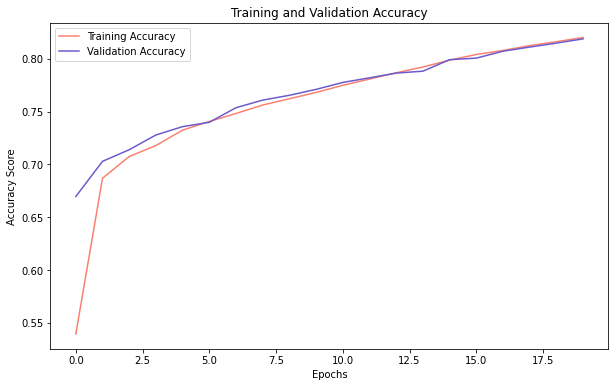

In [ ]:
#plot the graphs of the accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows both the training and testing/validation accuracy. In this model, the validation data is the testing or holdout data. Therefore, in the graph we are comparing the testing accuracy to the traning accuracy. In the visualization we can see that the training accuracy continues to increase steadily across the 20 epochs run. The testing accuracy closely follows the training acccuracy and reaches about .83 in this model iteration. 

## Reccurent Neural Network 2 - Adding Birdirectionality to the Model

In [ ]:
#recurrent neural net 2 -- bidirectional
#create the new model
model_bi = Sequential()

model_bi.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the bidirectional layer and recurrent layer
model_bi.add(Bidirectional(GRU(16)))
model_bi.add(Dense(20,activation = 'relu'))
model_bi.add(Dense(8, activation = 'softmax'))

#create earlystop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

#compile the model
model_bi.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Recall', 'Precision'])

In [ ]:
#fit the model
history_bi = model_bi.fit(x_train, y_train,
                         validation_data = (x_test,y_test),
                         epochs = 20,
                         batch_size = 256,
                          callbacks = [early_stop])

Epoch 1/20
384/384 [==============================] - 579s 1s/step - loss: 1.6403 - acc: 0.4570 - recall: 0.1488 - precision: 0.4551 - val_loss: 0.9835 - val_acc: 0.6719 - val_recall: 0.6349 - val_precision: 0.7137
Epoch 2/20
384/384 [==============================] - 578s 2s/step - loss: 0.9452 - acc: 0.6813 - recall: 0.6293 - precision: 0.7221 - val_loss: 0.8670 - val_acc: 0.7058 - val_recall: 0.6524 - val_precision: 0.7401
Epoch 3/20
384/384 [==============================] - 577s 2s/step - loss: 0.8598 - acc: 0.7045 - recall: 0.6517 - precision: 0.7402 - val_loss: 0.8247 - val_acc: 0.7109 - val_recall: 0.6720 - val_precision: 0.7415
Epoch 4/20
384/384 [==============================] - 590s 2s/step - loss: 0.8126 - acc: 0.7140 - recall: 0.6731 - precision: 0.7445 - val_loss: 0.8011 - val_acc: 0.7132 - val_recall: 0.6707 - val_precision: 0.7458
Epoch 5/20
384/384 [==============================] - 593s 2s/step - loss: 0.7898 - acc: 0.7177 - recall: 0.6800 - precision: 0.7470 - val_l

In [ ]:
#evaluate the bidirectional model on the testing data
model_bi.evaluate(x_test,y_test)

1024/1024 [==============================] - 193s 189ms/step - loss: 0.5706 - acc: 0.7999 - recall: 0.7719 - precision: 0.8239


[0.5705799460411072, 0.799945056438446, 0.771941602230072, 0.8238975405693054]

### Model Interpretation

In Model 2, bidirectionality was added to the recurrent layer of the neural network. Amino acid sequence has both an N-terminus and a C-terminus, therefore I thought it might be beneficial for the sequence to be read bidirectionally. None of the other layers or nodes were changed from Model 1, to see how introducing bidirectionality effected the accuracy of the model. In this model, trained across 20 epochs the balanced accuracy score was approximately 64%, while the f1-score was approximately 80%. These evaluation metrics are calculated in the cells below.

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model_bi.predict(x_test)
preds = np.argmax(preds, axis=1)

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.6390684410418265

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.7902767361473799

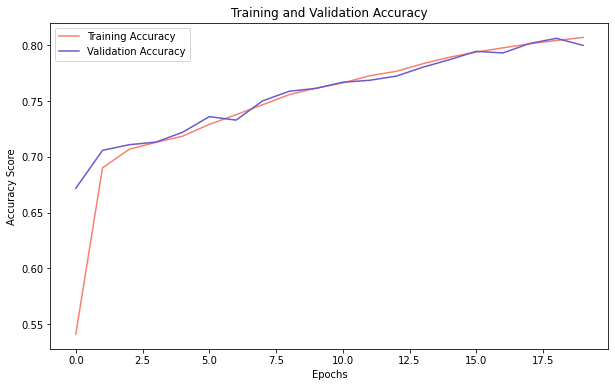

In [ ]:
#plot the graphs of the accuracy for the bidirectional model
plt.figure(figsize=(10,6))
plt.plot(history_bi.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(history_bi.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the training and testing/validation accuracy over the course of neural network training. The training and testing accuracies follow a very similar path as it trains over 20 epochs. The testing/holdout data of the model has a final accuracy of about 80%. 

## Recurrent Neural Network 3 - Convolutional Feature Extraction Layer

In [ ]:
#create the new model architecture for convolution
model_conv = Sequential()

model_conv.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model_conv.add(Conv1D(64,6, activation = 'relu'))
model_conv.add(MaxPooling1D(3))
model_conv.add(Bidirectional(GRU(16)))
model_conv.add(Dense(20, activation = 'relu'))
model_conv.add(Dense(8, activation = 'softmax'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_conv.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the network to the training data
history_conv = model_conv.fit(x_train, y_train,
                              validation_data = (x_test,y_test),
                              epochs = 40,
                              callbacks = [early_stop],
                              batch_size = 256)

Epoch 1/40
384/384 [==============================] - 366s 944ms/step - loss: 1.4209 - acc: 0.5472 - precision: 0.5736 - recall: 0.3181 - val_loss: 0.8549 - val_acc: 0.7092 - val_precision: 0.7456 - val_recall: 0.6504
Epoch 2/40
384/384 [==============================] - 370s 964ms/step - loss: 0.7969 - acc: 0.7230 - precision: 0.7675 - recall: 0.6639 - val_loss: 0.7071 - val_acc: 0.7489 - val_precision: 0.7912 - val_recall: 0.7022
Epoch 3/40
384/384 [==============================] - 378s 984ms/step - loss: 0.6454 - acc: 0.7729 - precision: 0.8128 - recall: 0.7238 - val_loss: 0.6269 - val_acc: 0.7870 - val_precision: 0.8259 - val_recall: 0.7382
Epoch 4/40
384/384 [==============================] - 378s 984ms/step - loss: 0.5400 - acc: 0.8167 - precision: 0.8496 - recall: 0.7819 - val_loss: 0.5417 - val_acc: 0.8188 - val_precision: 0.8528 - val_recall: 0.7858
Epoch 5/40
384/384 [==============================] - 380s 990ms/step - loss: 0.4572 - acc: 0.8497 - precision: 0.8743 - recall:

In [ ]:
#evaluate the convolutional network
model_conv.evaluate(x_test,y_test)

1024/1024 [==============================] - 80s 78ms/step - loss: 0.3328 - acc: 0.8940 - precision: 0.9057 - recall: 0.8848


[0.3328230381011963,
 0.8940023183822632,
 0.9057176113128662,
 0.8847798109054565]

### Model Interpretation

In Model 3, a 1-dimensional convolutional layer was introduced in hopes of extracting features to increase model performance. Protein domains are distinct functional/structural units of proteins, which are ultimately encoded by the amino acid sequence. The convolutional layer was added in hopes it would identify and extract common protein domains observed within a class and thus improve the predictive power of the model. The addition of the 1-dimensional convolutional layer occurred without changing any other nodes values from Model 2. Comparing the evaluation metrics of Model 2 to Model 3, we can see that the addition of the convolutional layer increased model accuracy, precision, and recall by approximately 10%. 

Calculated below, the balanced accuracy score is 77.7% and the f1-score is 89.3%.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

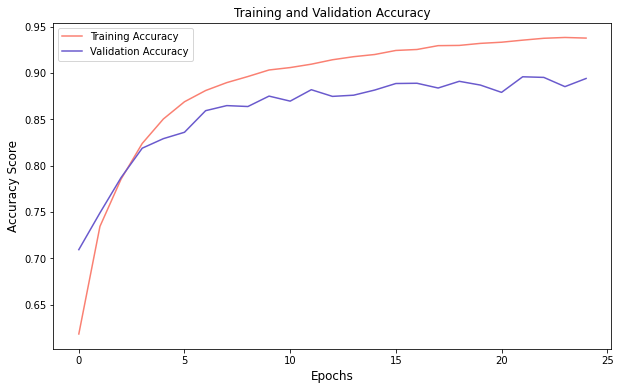

In [ ]:
#plot the accuracy
#plot the graphs of the accuracy for the convolutional model
plt.figure(figsize=(10,6))
plt.plot(history_conv.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(history_conv.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the training and testing/validation accuracy for the neural network as it trained over 25 epochs. During the course of training, the training accuracy continued to steadily increase as the model became more fit to that data. The training and testing/validation accuracies show slight divergence. The testing/validation accuracy for this model, Model 3, plateaus around 87-89%. 

In [ ]:
#the shape of y_test tells it is still one hot encoded
y_test.shape

(32746, 8)

In [ ]:
#one hot encoded y_test
y_test[0]

array([0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)
y_test_uncategory.shape

#make predictions
preds = model_conv.predict(x_test)
preds = np.argmax(preds, axis=1)

#get the labels for the summary table
label_order = ['rRNA Binding', 'DNA Binding', 'ATP Binding', 'Hormone', 'GTPase', 'NADH Dehydrogenase', 'Oxidoreductase', 'Toxin']

(32746,)

In [ ]:
#get the classification report for the convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.96      0.97      0.96      5013
       DNA Binding       0.79      0.86      0.82      6196
       ATP Binding       0.93      0.93      0.93     16172
           Hormone       0.70      0.59      0.64       379
            GTPase       0.91      0.85      0.88      1437
NADH Dehydrogenase       0.97      0.77      0.85      1060
    Oxidoreductase       0.49      0.38      0.43       812
             Toxin       0.90      0.88      0.89      1677

          accuracy                           0.89     32746
         macro avg       0.83      0.78      0.80     32746
      weighted avg       0.89      0.89      0.89     32746



### Table Interpretation

In the table above, we see a classifiction report for Model 3. This report breaks down how well the model performed on predicting the individual classes in the testing data. As we can see from the report above, Model 3 had a tough time correctly classifying the Oxidoreductase class. The f1-score for the Oxidoreductase class was .43, which is .21 points below the next lowest scoring class, Hormone. To create predictive improvement of the model, the Oxidoreductase class needs to be better classified. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.7768959702845009

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.8927178429006228

## Recurrent Neural Network 4 - 2 Convolutional Layers

In [ ]:
#create the new model architecture for model 4
model_2_conv = Sequential()

model_2_conv.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model_2_conv.add(Conv1D(64,10, activation = 'relu'))
model_2_conv.add(MaxPooling1D(5))

#add second convolutional layer and GRU layer
model_2_conv.add(Conv1D(32,6, activation = 'relu'))
model_2_conv.add(Bidirectional(GRU(32)))
model_2_conv.add(Dense(40, activation = 'relu'))
model_2_conv.add(Dropout(rate = .2))
model_2_conv.add(Dense(8, activation = 'softmax'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_2_conv.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_2_conv = model_2_conv.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
384/384 [==============================] - 318s 818ms/step - loss: 1.3439 - acc: 0.5376 - precision: 0.6212 - recall: 0.3434 - val_loss: 0.6969 - val_acc: 0.7464 - val_precision: 0.7819 - val_recall: 0.7052
Epoch 2/40
384/384 [==============================] - 313s 814ms/step - loss: 0.6567 - acc: 0.7725 - precision: 0.8047 - recall: 0.7319 - val_loss: 0.4536 - val_acc: 0.8506 - val_precision: 0.8753 - val_recall: 0.8276
Epoch 3/40
384/384 [==============================] - 313s 815ms/step - loss: 0.4521 - acc: 0.8562 - precision: 0.8779 - recall: 0.8319 - val_loss: 0.3847 - val_acc: 0.8693 - val_precision: 0.8903 - val_recall: 0.8472
Epoch 4/40
384/384 [==============================] - 313s 815ms/step - loss: 0.3672 - acc: 0.8833 - precision: 0.9029 - recall: 0.8639 - val_loss: 0.3500 - val_acc: 0.8881 - val_precision: 0.9006 - val_recall: 0.8777
Epoch 5/40
384/384 [==============================] - 313s 816ms/step - loss: 0.3126 - acc: 0.9004 - precision: 0.9194 - recall:

In [ ]:
#evaluate the model on the testing data
model_2_conv.evaluate(x_test, y_test)

1024/1024 [==============================] - 58s 56ms/step - loss: 0.2834 - acc: 0.9184 - precision: 0.9255 - recall: 0.9135


[0.2834151089191437,
 0.9184022545814514,
 0.9254710078239441,
 0.9135161638259888]

### Model Interpretation

In Model 4, another convolutional layer was added to the model and the hidden layer had more nodes added. Compared to Model 3, Model 4 performed better across all evaluation metrics by approximately 3 percentage points, ultimately predicting with approximately 91.8% accuracy on the testing/validation data. Calculated below, on balanced accuracy Model 4 scored 79.1% on balanced accuracy and 91.2% on f1-score. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

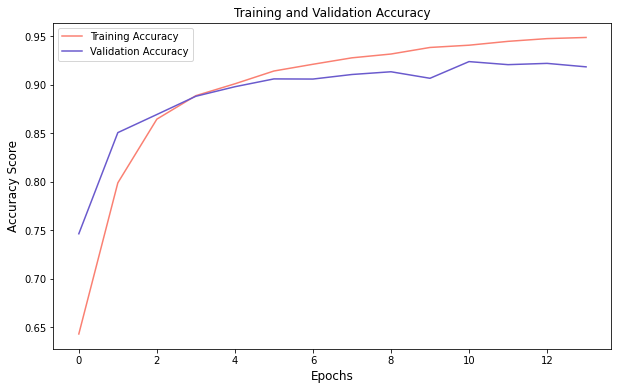

In [ ]:
#plot the accuracy
#plot the graphs of the accuracy for the 2 layer convolutional model
plt.figure(figsize=(10,6))
plt.plot(hist_2_conv.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_2_conv.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the accuracy of the training and testing/validation data over the 14 epochs run during model training. As we can see, the training accuracy increases over each of the epochs. However, the accuracy of the testing data plateaus at approximately 91%. 

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model_conv.predict(x_test)
preds = np.argmax(preds, axis=1)

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.7912597273834883

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9121204378612678

## Recurrent Neural Network 5 - Manipulating Node Numbers

In [ ]:
#create the new model architecture for model 4
model_5 = Sequential()

model_5.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model_5.add(Conv1D(64,12, activation = 'relu'))
model_5.add(MaxPooling1D(6))

#add second convolutional layer and GRU layer
model_5.add(Conv1D(32,8, activation = 'relu'))
model_5.add(Bidirectional(GRU(32)))
model_5.add(Dense(80, activation = 'relu'))
model_5.add(Dropout(rate = .2))
model_5.add(Dense(8, activation = 'softmax'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_5 = model_5.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
384/384 [==============================] - 362s 932ms/step - loss: 1.2570 - acc: 0.5869 - precision: 0.6561 - recall: 0.4145 - val_loss: 0.5869 - val_acc: 0.8032 - val_precision: 0.8325 - val_recall: 0.7656
Epoch 2/40
384/384 [==============================] - 356s 928ms/step - loss: 0.5461 - acc: 0.8243 - precision: 0.8499 - recall: 0.7936 - val_loss: 0.4534 - val_acc: 0.8554 - val_precision: 0.8712 - val_recall: 0.8387
Epoch 3/40
384/384 [==============================] - 356s 927ms/step - loss: 0.4015 - acc: 0.8740 - precision: 0.8934 - recall: 0.8557 - val_loss: 0.3820 - val_acc: 0.8760 - val_precision: 0.8970 - val_recall: 0.8563
Epoch 4/40
384/384 [==============================] - 356s 927ms/step - loss: 0.3232 - acc: 0.8996 - precision: 0.9165 - recall: 0.8830 - val_loss: 0.3469 - val_acc: 0.8892 - val_precision: 0.9012 - val_recall: 0.8779
Epoch 5/40
384/384 [==============================] - 356s 928ms/step - loss: 0.2876 - acc: 0.9093 - precision: 0.9256 - recall:

In [ ]:
#evaluate the mode
model_5.evaluate(x_test,y_test)

1024/1024 [==============================] - 53s 52ms/step - loss: 0.2407 - acc: 0.9256 - precision: 0.9344 - recall: 0.9197


[0.24066367745399475,
 0.9256092309951782,
 0.9343529939651489,
 0.919715404510498]

### Model Interpretation

In model 5, I began to manipulate the convolutional layer parameters as well as the number of nodes in the hidden layer of the model. At this point, I felt the architecture of the model was a good baseline to hypertune node parameters from. 

Increasing the number of nodes in the hidden layer, while slightly adapting the convolutional layers increased the evaluation metrics of the neutral network by about 1%, when compared to Model 4's epochs. Calculated below, the balanced accuracy is 83.7% and the f1-score is 92.3%. This hinted to me that a large number of nodes within the hidden layer could increase the predictive performance of the model.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

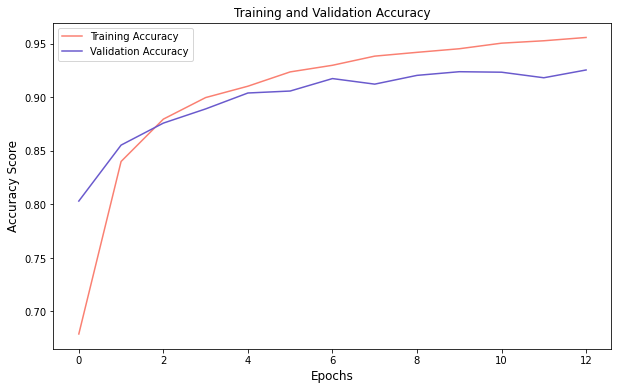

In [ ]:
#plot the accuracy
#plot the graphs of the accuracy for model 5
plt.figure(figsize=(10,6))
plt.plot(hist_5.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_5.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the training and validation/testing accuracy over the 13 epochs in Model 5 training. As we can see, the training accuracy continues to increase over each of the subsequent epochs. The testing/validation is more variable over the epochs and plateaus at approximately 91-92%. 

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)
y_test_uncategory.shape

#make predictions for 2 layer convolution model
preds = model_5.predict(x_test)
preds = np.argmax(preds, axis=1)

#labels for the summary table
label_order = ['rRNA Binding', 'DNA Binding', 'ATP Binding', 'Hormone', 'GTPase', 'NADH Dehydrogenase', 'Oxidoreductase', 'Toxin']

(32746,)

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.96      0.99      0.98      5013
       DNA Binding       0.89      0.86      0.87      6196
       ATP Binding       0.93      0.96      0.95     16172
           Hormone       0.84      0.70      0.77       379
            GTPase       0.94      0.95      0.95      1437
NADH Dehydrogenase       1.00      0.89      0.94      1060
    Oxidoreductase       0.60      0.42      0.49       812
             Toxin       0.91      0.92      0.92      1677

          accuracy                           0.93     32746
         macro avg       0.89      0.84      0.86     32746
      weighted avg       0.92      0.93      0.92     32746



### Table Interpretation

The table above is the classification report for Model 5. This report breaks down how well the model performed on predicting the individual classes in the testing data. As we can see from the report above, Model 5, much like Model 3, continued to have a tough time correctly classifying the Oxidoreductase class. The f1-score for the Oxidoreductase class was .49, which is .28 points below the next lowest scoring class, Hormone. To create predictive improvement of the model, the Oxidoreductase class needs to be better classified. Outside of the Oxidoreductase and Hormone class, f1-scores were .87 and higher. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.8368738345638569

In [ ]:
#get the f1-score of the model
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9233905400543914

## Recurrent Neural Network 6 - Best Model in Notebook

In [ ]:
#create the new model architecture for model 6
model_6 = Sequential()

model_6.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model_6.add(Conv1D(128,32, activation = 'relu'))
model_6.add(MaxPooling1D(6))

#add second convolutional layer and GRU layer
model_6.add(Conv1D(64,24, activation = 'relu'))
model_6.add(Bidirectional(GRU(64)))
model_6.add(Dense(120, activation = 'relu'))
model_6.add(Dropout(rate = .2))
model_6.add(Dense(8, activation = 'softmax'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_6 = model_6.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
384/384 [==============================] - 591s 2s/step - loss: 1.0128 - acc: 0.6658 - precision: 0.7230 - recall: 0.5720 - val_loss: 0.4044 - val_acc: 0.8738 - val_precision: 0.8848 - val_recall: 0.8635
Epoch 2/40
384/384 [==============================] - 583s 2s/step - loss: 0.2910 - acc: 0.9084 - precision: 0.9261 - recall: 0.8928 - val_loss: 0.2445 - val_acc: 0.9201 - val_precision: 0.9310 - val_recall: 0.9126
Epoch 3/40
384/384 [==============================] - 583s 2s/step - loss: 0.1523 - acc: 0.9525 - precision: 0.9609 - recall: 0.9446 - val_loss: 0.2211 - val_acc: 0.9283 - val_precision: 0.9409 - val_recall: 0.9174
Epoch 4/40
384/384 [==============================] - 583s 2s/step - loss: 0.1030 - acc: 0.9678 - precision: 0.9736 - recall: 0.9628 - val_loss: 0.1799 - val_acc: 0.9449 - val_precision: 0.9517 - val_recall: 0.9394
Epoch 5/40
384/384 [==============================] - 583s 2s/step - loss: 0.0714 - acc: 0.9776 - precision: 0.9817 - recall: 0.9747 - val_l

In [ ]:
#evaluate the model on the training data
model_6.evaluate(x_test,y_test)

1024/1024 [==============================] - 58s 57ms/step - loss: 0.2153 - acc: 0.9429 - precision: 0.9469 - recall: 0.9400


[0.21533355116844177,
 0.9428938031196594,
 0.9468746185302734,
 0.9399926662445068]

### Model Interpretation

In Model 6, continued manipulations of the layers occurred. I continued to increase the number of hidden layer nodes and manipulate the filter and kernel sizes of the convolutional layers. The architecture for Model 6 saw a slight increase in performance from that in Model 5 - all of the evaluation metrics of the neural net training scored approximately 94%. Calculated below, the model scored approximately 90.9% on balanced accuracy and 94.4% on the f1-score.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

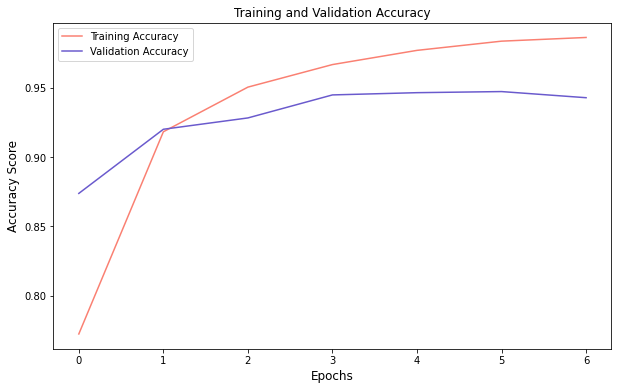

In [ ]:
#plot the accuracy
#plot the graphs of the accuracy for model 6
plt.figure(figsize=(10,6))
plt.plot(hist_6.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_6.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the accuracy for the training and testing/validation sets over the 7 epochs the neural network trained. As we can see the training accuracy increased over all of the epochs. The testing/validation accuracy, while much more variable than the training accuracy, plateaued fairly quickly during training around 94%. 

In [ ]:
#save model 6 to google colab
#model_6.save("rnn_model_6.h5")

In [ ]:
#download the 2 layer convolutional model to local machine when using google colab
#from google.colab import files
#files.download("rnn_model_6.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)
y_test_uncategory.shape

(32746,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

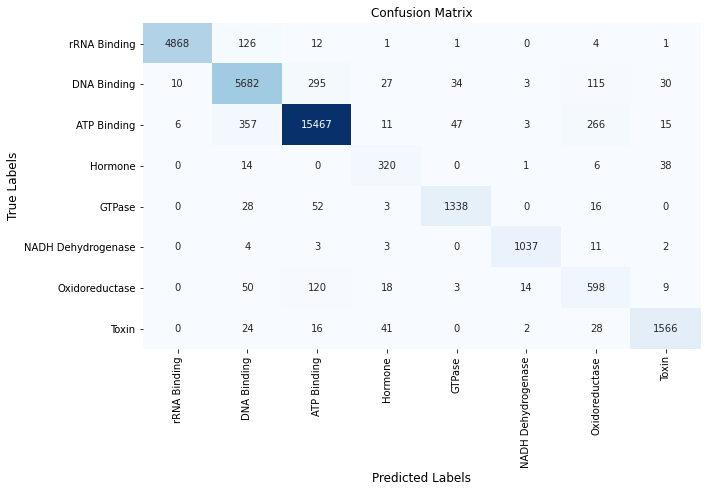

In [ ]:
#make predictions for 2 layer convolution model
preds = model_6.predict(x_test)
preds = np.argmax(preds, axis=1)

#create a confusion matrix
confusion = confusion_matrix(y_test_uncategory, preds)

#plot confusion matrix https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#fmt = 'g' to suppress scientific notation https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(confusion, annot = True, ax = ax, fmt = 'g', cmap = 'Blues', cbar = False);

label_order = ['rRNA Binding', 'DNA Binding', 'ATP Binding', 'Hormone', 'GTPase', 'NADH Dehydrogenase', 'Oxidoreductase', 'Toxin']

#set the labels
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels',fontsize=12) 
ax.set_title('Confusion Matrix', fontsize = 12) 
ax.xaxis.set_ticklabels(label_order, rotation = 90)
ax.yaxis.set_ticklabels(label_order, rotation = 0)

# uncomment to save the image locally
# from google.colab import files
# plt.savefig("model_6_confusion.png", bbox_inches='tight', dpi=300)
# files.download("model_6_confusion.png");

### Visualization Interpretation

The visualization above is a confusion matrix for the best performing model at this stage of the project. The confusion matrix takes the predictions of the models and compares them to the true labels of those predictions. Above, the true and predicted labels for each class are shown. The confusion matrix allows us to see where a large proportion of the misclassifications are occuring within the data. Unsurprisingly, a high number of misclassifications came from the ATP binding and DNA binding classes. There were protein sequences in modeling which had both of these functions attributed to them. Another area of large portions of misclassifications came from the ATP binding/DNA binding and Oxidoreductase class. 

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       1.00      0.97      0.98      5013
       DNA Binding       0.90      0.92      0.91      6196
       ATP Binding       0.97      0.96      0.96     16172
           Hormone       0.75      0.84      0.80       379
            GTPase       0.94      0.93      0.94      1437
NADH Dehydrogenase       0.98      0.98      0.98      1060
    Oxidoreductase       0.57      0.74      0.64       812
             Toxin       0.94      0.93      0.94      1677

          accuracy                           0.94     32746
         macro avg       0.88      0.91      0.89     32746
      weighted avg       0.95      0.94      0.94     32746



### Table Interpretation

The table above is the classification report for Model 6. This report breaks down how well the model performed on predicting the individual classes in the testing data. Model 6 had a slightly better overall accuracy than Model 5 on all evaluation metrics, and it performed .15 points better at correctly classifying the Oxidoreductase class. The accuracy improved as there was a higher success rate for classification of all of the classes besides Oxidoreductase, which is reflected in the larger f1-scores for almost all of the other classes within the table. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.9085654631587932

In [ ]:
#get the f1-score of the model
f1_score(y_test_uncategory, preds, average = 'weighted')

0.944235391789168

## Recurrent Neural Network 7 - Continued Layer Manipulation

In [ ]:
#create the new model architecture for model 7
model_7 = Sequential()

model_7.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model_7.add(Conv1D(164,32, activation = 'relu'))
model_7.add(MaxPooling1D(6))

#add second convolutional layer and GRU layer
model_7.add(Conv1D(64,24, activation = 'relu'))
model_7.add(Bidirectional(GRU(64)))
model_7.add(Dense(240, activation = 'relu'))
model_7.add(Dropout(rate = .2))
model_7.add(Dense(8, activation = 'softmax'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_7 = model_7.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
384/384 [==============================] - 745s 2s/step - loss: 1.0244 - acc: 0.6641 - precision: 0.7196 - recall: 0.5699 - val_loss: 0.3268 - val_acc: 0.8919 - val_precision: 0.9056 - val_recall: 0.8816
Epoch 2/40
384/384 [==============================] - 740s 2s/step - loss: 0.2646 - acc: 0.9168 - precision: 0.9334 - recall: 0.9025 - val_loss: 0.2321 - val_acc: 0.9241 - val_precision: 0.9357 - val_recall: 0.9130
Epoch 3/40
384/384 [==============================] - 740s 2s/step - loss: 0.1342 - acc: 0.9581 - precision: 0.9659 - recall: 0.9513 - val_loss: 0.2005 - val_acc: 0.9362 - val_precision: 0.9453 - val_recall: 0.9292
Epoch 4/40
384/384 [==============================] - 740s 2s/step - loss: 0.0773 - acc: 0.9763 - precision: 0.9800 - recall: 0.9732 - val_loss: 0.2207 - val_acc: 0.9401 - val_precision: 0.9448 - val_recall: 0.9373
Epoch 5/40
384/384 [==============================] - 739s 2s/step - loss: 0.0515 - acc: 0.9841 - precision: 0.9867 - recall: 0.9825 - val_l

In [ ]:
#evaluate the model
model_7.evaluate(x_test, y_test)

1024/1024 [==============================] - 60s 58ms/step - loss: 0.2196 - acc: 0.9445 - precision: 0.9482 - recall: 0.9417


[0.21957005560398102,
 0.9444817900657654,
 0.9482488036155701,
 0.9417333602905273]

### Model Interpretation

Model 7, with continued manipulation of the hidden layer and convolutional layer inputs. The accuracy of Model 7 was approximately 94.5%. While all of the evaluation metrics during neural network training scored slightly better than those in Model 6, the balanced accuracy and classification report show that Model 7 performed worse in classifying the Oxidoreductase class. Calculated below, the balanced accuracy is 87.1% and the f1-score is 94.3%. Based on the desired pair-wise evaluation metrics, Model 6 performed better than Model 7.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

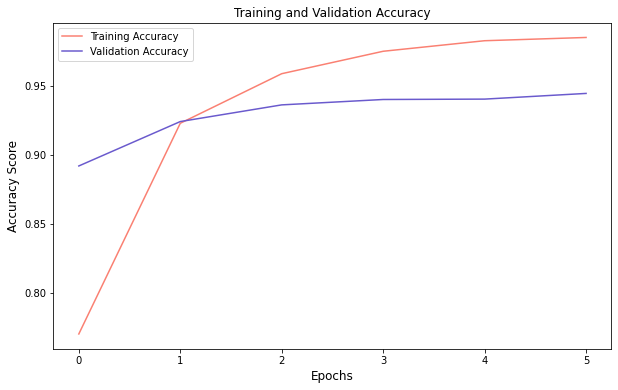

In [ ]:
#plot the accuracy
#plot the graphs of the accuracy for model 7
plt.figure(figsize=(10,6))
plt.plot(hist_7.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_7.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the accuracy of the training and testing/validation data across the 6 epochs of neural net training. Similarly to the other models trained, Model 7 training accuracy increased over the course of neural net training. The testing/validation accuracy, for the most part, also increased over the course of training. Ultimately, the testing accuracy was approximately 94.5%.

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)
y_test_uncategory.shape

#make predictions for recurrent neural net model 7
preds = model_7.predict(x_test)
preds = np.argmax(preds, axis=1)

#get the labels for the summary
label_order = ['rRNA Binding', 'DNA Binding', 'ATP Binding', 'Hormone', 'GTPase', 'NADH Dehydrogenase', 'Oxidoreductase', 'Toxin']

(32746,)

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.99      0.99      0.99      5013
       DNA Binding       0.92      0.90      0.91      6196
       ATP Binding       0.94      0.98      0.96     16172
           Hormone       0.84      0.81      0.82       379
            GTPase       0.96      0.93      0.94      1437
NADH Dehydrogenase       0.99      0.94      0.96      1060
    Oxidoreductase       0.81      0.50      0.62       812
             Toxin       0.94      0.93      0.94      1677

          accuracy                           0.94     32746
         macro avg       0.92      0.87      0.89     32746
      weighted avg       0.94      0.94      0.94     32746



### Table Interpretation

The table above is the classification report for Model 7. This report breaks down how well the model performed on predicting the individual classes in the testing data. In the report above, we see the best f1-scores for each of the classes so far. The Oxidoreductase class, while still the most misclassified class of the group, has an f1-score of .62. All other classes, except for the Hormone, class have a f1-score above .90. The Hormone class is the smallest class in the data, only sporting about 1% of the total observations has an f1-score of .82. In order to improve the classification of the Hormone class a larger number of observations is needed.

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.8708710779475262

In [ ]:
#get the f1-score of the model
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9426817164003072

## Next Notebook: oversample_model_rnn.ipynb

In the next iteration of modeling, the module imblearn was used to oversample the minority classes in order to create balanced classes. 